<a href="https://colab.research.google.com/github/samlucas28/Thesis-python-scripts/blob/main/Full_model_PSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PSA iteration 1/40
PSA iteration 2/40
PSA iteration 3/40
PSA iteration 4/40
PSA iteration 5/40
PSA iteration 6/40
PSA iteration 7/40
PSA iteration 8/40
PSA iteration 9/40
PSA iteration 10/40
PSA iteration 11/40
PSA iteration 12/40
PSA iteration 13/40
PSA iteration 14/40
PSA iteration 15/40
PSA iteration 16/40
PSA iteration 17/40
PSA iteration 18/40
PSA iteration 19/40
PSA iteration 20/40
PSA iteration 21/40
PSA iteration 22/40
PSA iteration 23/40
PSA iteration 24/40
PSA iteration 25/40
PSA iteration 26/40
PSA iteration 27/40
PSA iteration 28/40
PSA iteration 29/40
PSA iteration 30/40
PSA iteration 31/40
PSA iteration 32/40
PSA iteration 33/40
PSA iteration 34/40
PSA iteration 35/40
PSA iteration 36/40
PSA iteration 37/40
PSA iteration 38/40
PSA iteration 39/40
PSA iteration 40/40

Decision Tree PSA complete.
control_cost: 9459.58 (95% CI: 2369.36, 15250.92)
interv_cost: 23273.11 (95% CI: 19013.81, 28781.88)
control_symptomatic_detectio

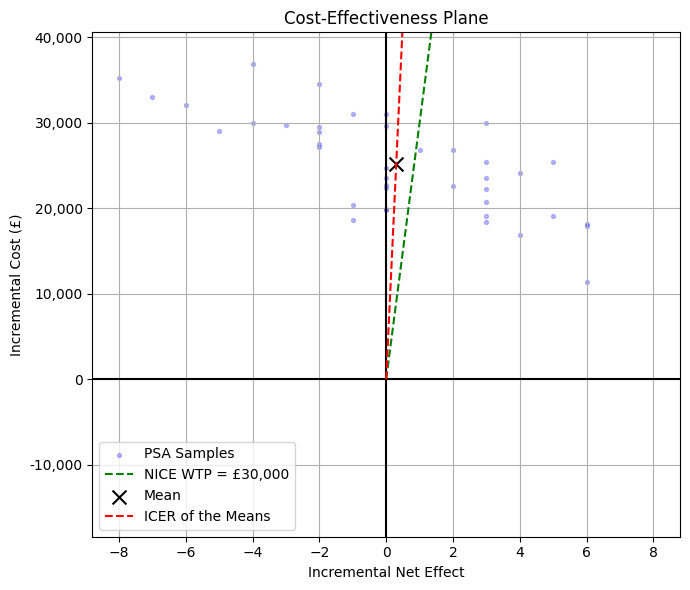

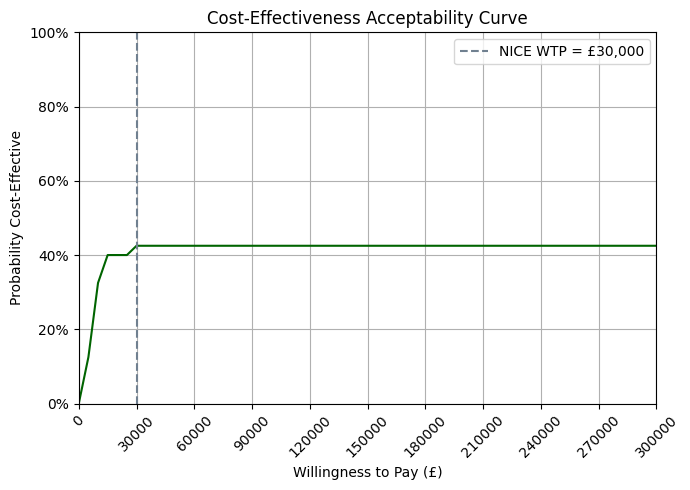

In [ ]:
# ----------------------------------------------------------------
# FULL MODEL PSA (DECISION TREE + MARKOV)
# ----------------------------------------------------------------

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable, Union
import numpy as np
from scipy.stats import beta, gamma, dirichlet, lognorm
import pandas as pd

# See python version
import sys
print(sys.version)

# 1. DEFINING THE COHORT OF WOMEN
# -----------------------------------
rng = np.random.default_rng(seed=1)

N = 50000

cohort = pd.DataFrame({
    "start_age": rng.integers(38, 46, N),
    "imd": rng.integers(1, 11, N)
})

# 2. DISTRIBUTIONS
# ------------------

def dist_lognormal(mu_l: float, sigma_l: float):
    return lognorm(s=sigma_l, scale=np.exp(mu_l))

def dist_beta(a: float, b: float):
    return beta(a, b)

def dist_gamma(k: float, rate: float):
    return gamma(k, scale=1/rate)

def dist_dirichlet(alphas: List[float]):
    return dirichlet(alphas)

# 3. ALL INPUTS
# ------------------

PARAMS: Dict[str, Dict[str, Union[float, Tuple, list]]] = {
    "COST_FHQS_TEXT":        dist_lognormal(3.091, 0.618),
    "COST_UPTAKE":           dist_gamma(32.83, 3.29),
    "COST_SYMPTOM":          dist_gamma(894.8, 0.780),
    "COST_HIGH_RISK":        351.88,
    "COST_REFERRAL":         66.93,

    "P_FHQS_UPTAKE":         dist_beta(203, 1277),
    "P_RISK_SPLIT_FHQS":     dist_dirichlet([88.7, 10.3, 1.0]),

    "P_SYMPT_LOWRISK":       dist_beta(35008, 2413112),
    "P_SYMPT_UNCLASSIFIED":  dist_beta(44712, 2715288),

    "IMD_REFERRAL": {
        1:  dist_beta(5,   19224),
        2:  dist_beta(17,  56094),
        3:  dist_beta(24,  67475),
        4:  dist_beta(27,  67777),
        5:  dist_beta(40,  89535),
        6:  dist_beta(60, 119543),
        7:  dist_beta(58, 107788),
        8:  dist_beta(65, 111408),
        9:  dist_beta(71, 112480),
        10: dist_beta(60, 89261),
    },

    "P_RISK_SPLIT_REFERRAL":  dist_dirichlet([50.3, 40.4, 9.3]),
}

# 4. NODE CLASSES
# ------------------

@dataclass
class Node:
    def expected_cost(self) -> float:
        raise NotImplementedError

    def simulate(self) -> Tuple[float, str]:
        raise NotImplementedError

@dataclass
class Terminal(Node):
    cost: Union[float, Callable[[], float]]
    label: str = "TERMINAL"

    def draw_cost(self) -> float:
        return self.cost() if callable(self.cost) else self.cost

    def expected_cost(self) -> float:
        return self.draw_cost()

    def simulate(self) -> Tuple[float, str]:
        return self.draw_cost(), self.label

@dataclass
class Chance(Node):
    branches: List[Tuple[Callable[[], float], Node]]

    def expected_cost(self) -> float:
        ec = 0.0
        for p_fn, node in self.branches:
            p = p_fn()
            ec += p * node.expected_cost()
        return ec

    def simulate(self) -> Tuple[float, str]:
        probs = np.array([p_fn() for p_fn, _ in self.branches])
        probs /= probs.sum()
        choice = np.random.choice(len(self.branches), p=probs)
        cost, label = self.branches[choice][1].simulate()
        return cost, label

@dataclass
class Decision(Node):
    options: Dict[str, Node]

    def expected_cost(self, option: str) -> float:
        return self.options[option].expected_cost()

    def simulate(self, option: str) -> Tuple[float, str]:
        return self.options[option].simulate()

@dataclass
class AddCost(Node):
    cost: Union[float, Callable[[], float]]
    next_node: Node

    def _draw(self):
        return self.cost() if callable(self.cost) else self.cost

    def expected_cost(self):
        if callable(self.cost) and hasattr(self.cost, "mean"):
            return self.cost.mean() + self.next_node.expected_cost()
        return self._draw() + self.next_node.expected_cost()

    def simulate(self):
        c_here = self._draw()
        c_next, lbl = self.next_node.simulate()
        return c_here + c_next, lbl

# 5. TREE BUILDING
# ------------------

def make_tree(imd_decile: int) -> Decision:
    no_sympt_term      = Terminal(0.0, label="NO_SYMPT_PRESENT")
    sympt_term         = Terminal(PARAMS["COST_SYMPTOM"].rvs, label="SYMPT_PRESENT")
    mod_risk_term      = Terminal(0.0, label="MODERATE_RISK")
    high_risk_term     = Terminal(PARAMS["COST_HIGH_RISK"], label="HIGH_RISK")

    def make_sympt_node(beta_dist):
        p_sympt = beta_dist.rvs()
        return Chance([
            (lambda p=p_sympt: p, sympt_term),
            (lambda p=p_sympt: 1 - p, no_sympt_term),
        ])

    low_risk_sympt_node = make_sympt_node(PARAMS["P_SYMPT_LOWRISK"])
    unclass_sympt_node  = make_sympt_node(PARAMS["P_SYMPT_UNCLASSIFIED"])

    def dirichlet_probs(dist):
        draw = dist.rvs()[0]
        return draw[0], draw[1], draw[2]

    def fhqs_risk_node():
        p_low, p_mod, p_high = dirichlet_probs(PARAMS["P_RISK_SPLIT_FHQS"])
        return Chance([
            (lambda p=p_low: p, low_risk_sympt_node),
            (lambda p=p_mod: p, mod_risk_term),
            (lambda p=p_high: p, high_risk_term),
        ])

    def referral_risk_node():
        p_low, p_mod, p_high = dirichlet_probs(PARAMS["P_RISK_SPLIT_REFERRAL"])
        return Chance([
            (lambda p=p_low: p, low_risk_sympt_node),
            (lambda p=p_mod: p, mod_risk_term),
            (lambda p=p_high: p, high_risk_term),
        ])

    p_uptake_val = PARAMS["P_FHQS_UPTAKE"].rvs()
    uptake_node = Chance([
        (lambda: p_uptake_val, AddCost(PARAMS["COST_UPTAKE"].rvs, fhqs_risk_node())),
        (lambda: 1 - p_uptake_val, unclass_sympt_node),
    ])

    send_text_branch = AddCost(PARAMS["COST_FHQS_TEXT"].rvs, uptake_node)

    p_referral_val = PARAMS["IMD_REFERRAL"][imd_decile].rvs()
    referral_node = Chance([
        (lambda: p_referral_val, AddCost(PARAMS["COST_REFERRAL"], referral_risk_node())),
        (lambda: 1 - p_referral_val, unclass_sympt_node),
    ])

    return Decision({
        "SEND_TEXT": send_text_branch,
        "NO_TEXT": referral_node,
    })

# 6. SIMULATE COHORT FUNCTION
# -----------------------------

def simulate_cohort_separate_risks(cohort: pd.DataFrame) -> Tuple[dict, dict, dict, dict]:
    # Simulate the cohort through the tree for both arms.
    # Returns total and by-IMD statistics dictionaries.
    imd_levels = range(1, 11)

    total_control = {
        "cost": 0.0,
        "symptomatic_detections": 0,
        "moderate_risk": 0,
        "high_risk": 0,
    }
    total_interv = total_control.copy()

    results_control_by_imd = {imd: {"cost": 0.0, "symptomatic_detections": 0, "moderate_risk": 0, "high_risk": 0} for imd in imd_levels}
    results_interv_by_imd = {imd: {"cost": 0.0, "symptomatic_detections": 0, "moderate_risk": 0, "high_risk": 0} for imd in imd_levels}

    for _, person in cohort.iterrows():
        imd = person["imd"]
        tree = make_tree(imd)

        # Control arm
        cost_c, label_c = tree.simulate("NO_TEXT")
        total_control["cost"] += cost_c
        if label_c == "SYMPT_PRESENT":
            total_control["symptomatic_detections"] += 1
            results_control_by_imd[imd]["symptomatic_detections"] += 1
        elif label_c == "MODERATE_RISK":
            total_control["moderate_risk"] += 1
            results_control_by_imd[imd]["moderate_risk"] += 1
        elif label_c == "HIGH_RISK":
            total_control["high_risk"] += 1
            results_control_by_imd[imd]["high_risk"] += 1
        results_control_by_imd[imd]["cost"] += cost_c

        # Intervention arm
        cost_i, label_i = tree.simulate("SEND_TEXT")
        total_interv["cost"] += cost_i
        if label_i == "SYMPT_PRESENT":
            total_interv["symptomatic_detections"] += 1
            results_interv_by_imd[imd]["symptomatic_detections"] += 1
        elif label_i == "MODERATE_RISK":
            total_interv["moderate_risk"] += 1
            results_interv_by_imd[imd]["moderate_risk"] += 1
        elif label_i == "HIGH_RISK":
            total_interv["high_risk"] += 1
            results_interv_by_imd[imd]["high_risk"] += 1
        results_interv_by_imd[imd]["cost"] += cost_i

    # Lists to store individual-level data with risk labels
    indiv_data_control = []
    indiv_data_interv = []

    for _, person in cohort.iterrows():
        imd = person["imd"]
        start_age = person["start_age"]
        tree = make_tree(imd)

        # Control arm
        cost_c, label_c = tree.simulate("NO_TEXT")

        # Store individual data for control
        indiv_data_control.append({
            "start_age": start_age,
            "imd": imd,
            "risk": label_c.lower()
        })

        # Intervention arm
        cost_i, label_i = tree.simulate("SEND_TEXT")

        # Store individual data for intervention
        indiv_data_interv.append({
            "start_age": start_age,
            "imd": imd,
            "risk": label_i.lower()
        })

    # Convert lists to DataFrames for markov
    indiv_data_control_df = pd.DataFrame(indiv_data_control)
    indiv_data_interv_df = pd.DataFrame(indiv_data_interv)

    return total_control, results_control_by_imd, total_interv, results_interv_by_imd, indiv_data_control_df, indiv_data_interv_df


# 7. Creation of confidence intervals
# -------------------------------------

import numpy as np

def summarize_with_ci(data, alpha=0.05):

    arr = np.array(data)
    mean = np.mean(arr)
    lower = np.percentile(arr, 100 * alpha / 2)
    upper = np.percentile(arr, 100 * (1 - alpha / 2))
    return mean, lower, upper


# 8. MARKOV MODEL
# ------------------
import numpy as np
import pandas as pd
from scipy.stats import beta, gamma


# 9. PARAMETERS
# ----------------
STATES = ["Healthy_TN", "Healthy_FP", "Cancer_Undetected", "Cancer_Detected"]
ALL_STATES = STATES + ["Exited"]
RISK_GROUPS = ["high_risk", "moderate_risk"]
AGE_RANGE = range(38, 50)
CONF_LEVEL = 0.95

# Sensitivity and Specificity
SENS_MEAN, SENS_L, SENS_U = 0.780, 0.730, 0.830
SPEC_MEAN, SPEC_L, SPEC_U = 0.90, 0.897, 0.903
UP_MEAN, UP_L, UP_U = 0.824, 0.754, 0.894

# 10. COST PARAMETERS
# -----------------
cost_params = {
    "Healthy_TN": 196.40,
    "Healthy_FP_alpha": 207.78,
    "Healthy_FP_beta": 0.376,
    "Cancer_Undetected": 196.40,
    "Cancer_Detected_alpha": 536,
    "Cancer_Detected_beta": 0.604
}

fixed_cost_sample = {
    "Healthy_TN": 196.40,
    "Healthy_FP": 552.66,
    "Cancer_Undetected": 196.40,
    "Cancer_Detected": 887.66
}

# 11. BETA FITTING
# ---------------
def beta_from_ci(mean, low, high, conf=CONF_LEVEL):
    z = abs(beta.ppf([(1-conf)/2, 1-(1-conf)/2], 1, 1) - 0.5)[0]
    sd = (high - low) / (2*z)
    var = sd**2
    tmp = mean * (1 - mean) / var - 1
    return mean * tmp, (1 - mean) * tmp

α_sens, β_sens = beta_from_ci(SENS_MEAN, SENS_L, SENS_U)
α_spec, β_spec = beta_from_ci(SPEC_MEAN, SPEC_L, SPEC_U)
α_up, β_up = beta_from_ci(UP_MEAN, UP_L, UP_U)


# 12. COST SAMPLING FUNCTION
# -----------------------
def sample_costs(rng, params):
    return {
        "Healthy_TN": params["Healthy_TN"],
        "Healthy_FP": rng.gamma(params["Healthy_FP_alpha"], params["Healthy_FP_beta"]),
        "Cancer_Undetected": params["Cancer_Undetected"],
        "Cancer_Detected": rng.gamma(params["Cancer_Detected_alpha"], params["Cancer_Detected_beta"])
    }



# 13. LOAD PREVALENCE DATA
# ----------------------
prevalence_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Markov prevelance table.xlsx")
prevalence_df.columns = prevalence_df.columns.str.strip()

# 14. HELPER FUNCTIONS
# -----------------------
def band_for_age(age):
    return "38-39" if age < 40 else ("40-44" if age < 45 else "45-49")

def make_matrix(prev, sens, spec, uptake):
    tn = (1 - prev) * spec
    fp = (1 - prev) * (1 - spec)
    fn = prev * (1 - sens)
    tp = prev * sens
    p = {"TN": tn, "FP": fp, "FN": fn, "TP": tp, "sens": sens}

    M = pd.DataFrame(0., index=ALL_STATES, columns=ALL_STATES)
    M.loc["Healthy_TN", "Healthy_TN"] = (1 - uptake) + uptake * p["TN"]
    M.loc["Healthy_TN", "Healthy_FP"] = uptake * p["FP"]
    M.loc["Healthy_TN", "Cancer_Undetected"] = uptake * p["FN"]
    M.loc["Healthy_TN", "Cancer_Detected"] = uptake * p["TP"]

    M.loc["Healthy_FP", "Healthy_FP"] = (1 - uptake) + uptake * p["FP"]
    M.loc["Healthy_FP", "Healthy_TN"] = uptake * p["TN"]
    M.loc["Healthy_FP", "Cancer_Undetected"] = uptake * p["FN"]
    M.loc["Healthy_FP", "Cancer_Detected"] = uptake * p["TP"]

    M.loc["Cancer_Undetected", "Cancer_Undetected"] = (1 - uptake) + uptake * (1 - p["sens"])
    M.loc["Cancer_Undetected", "Cancer_Detected"] = uptake * p["sens"]

    M.loc["Cancer_Detected", "Exited"] = 1.0
    M.loc["Exited", "Exited"] = 1.0
    return M


# 15. MATRIX BUILDER
# ------------------
def build_matrices(prevalence_df, rng):
    uptake_draw = rng.beta(α_up, β_up)
    sens_draw = rng.beta(α_sens, β_sens)
    spec_draw = rng.beta(α_spec, β_spec)

    matrices = {}
    for _, row in prevalence_df.iterrows():
        risk = row["risk"]
        age_band = row["age_band"]
        prevalence = float(row["prevelance"])
        matrices[(risk, age_band)] = make_matrix(prevalence, sens_draw, spec_draw, uptake_draw)
    return matrices


# 16. CANCER DETECTION FUNCTION
# --------------------------
def cancers_detected_before_50_grouped(matrices, grouped_df):
    detected = 0
    for _, row in grouped_df.iterrows():
        risk, start_age, n = row["risk"], int(row["start_age"]), int(row["n"])
        dist = pd.Series(0., index=ALL_STATES)
        dist["Healthy_TN"] = n
        for age in range(start_age, 50):
            age_band = band_for_age(age)
            dist = dist @ matrices[(risk, age_band)]
        detected += dist["Exited"]
    return int(detected)


# 17. COST CALCULATOR
# -----------------
def calculate_costs(matrices, grouped_df, cost_sample, discount_rate=0.035):
    total_cost = 0
    for _, row in grouped_df.iterrows():
        risk, start_age, n = row["risk"], row["start_age"], row["n"]
        dist = pd.Series(0., index=ALL_STATES)
        dist["Healthy_TN"] = n
        cohort_cost = 0
        for i, age in enumerate(range(start_age, 50)):
            age_band = band_for_age(age)
            M = matrices[(risk, age_band)]
            year_cost = (
                dist["Healthy_TN"] * cost_sample["Healthy_TN"] +
                dist["Healthy_FP"] * cost_sample["Healthy_FP"] +
                dist["Cancer_Undetected"] * cost_sample["Cancer_Undetected"] +
                dist["Cancer_Detected"] * cost_sample["Cancer_Detected"]
            )
            cohort_cost += year_cost / ((1 + discount_rate) ** i)
            dist = dist @ M
        total_cost += cohort_cost
    return total_cost


# 18. PREVELANCE TABLE
# ----------------------

def load_prevalence_table(path):
    df = pd.read_excel(path)
    df.columns = df.columns.str.strip()
    return df


# 19. PSA LOOP
# ----------------
def psa_cost_effectiveness(patients_df, excel_path, cost_params, n_psa=1000, seed=None):
    prevalence_df = load_prevalence_table(excel_path)
    grouped = patients_df.groupby(["risk", "start_age"]).size().reset_index(name="n")
    rng = np.random.default_rng(seed)

    costs = []
    effects = []
    cost_per_case = []

    for _ in range(n_psa):
        mats = build_matrices(prevalence_df, rng)
        effect = cancers_detected_before_50_grouped(mats, grouped)

        cost_sample = sample_costs(rng, cost_params)
        cost = calculate_costs(mats, grouped, cost_sample)

        costs.append(cost)
        effects.append(effect)
        cost_per_case.append(cost / effect if effect > 0 else np.nan)

    return np.array(costs), np.array(effects), np.array(cost_per_case)

# 20. RUNNING THE PSA LOOP
# ---------------------------

if __name__ == "__main__":
    N_PSA = 500  # Number of simulation
    imd_levels = range(1, 11)

    # PSA result containers for decision tree
    psa_totals = {
        "control_cost": [],
        "interv_cost": [],
        "control_symptomatic_detections": [],
        "interv_symptomatic_detections": [],
        "control_moderate_risk": [],
        "interv_moderate_risk": [],
        "control_high_risk": [],
        "interv_high_risk": [],
    }

    psa_by_imd = {
        key: {imd: [] for imd in imd_levels}
        for key in psa_totals.keys()
    }

    # PSA result containers for markov
    markov_results = {
        "control_cost": [],
        "control_effects": [],
        "control_cost_per_case": [],
        "interv_cost": [],
        "interv_effects": [],
        "interv_cost_per_case": [],
    }

    # PSA result containers for markov by IMD

    markov_results_by_imd = {
        imd: {
            "control_cost": [],
            "control_effects": [],
            "control_cost_per_case": [],
            "interv_cost": [],
            "interv_effects": [],
            "interv_cost_per_case": [],
        }
        for imd in imd_levels
    }


    excel_path = ("/content/drive/My Drive/Colab Notebooks/Markov prevelance table.xlsx")

    for i in range(N_PSA):
        print(f"PSA iteration {i+1}/{N_PSA}")

        # Reset stochastic parameters for this iteration
        global PARAMS
        PARAMS = {
            "COST_FHQS_TEXT":        dist_lognormal(3.091, 0.618),
            "COST_UPTAKE":           dist_gamma(32.83, 3.29),
            "COST_SYMPTOM":          dist_gamma(894.8, 0.780),
            "COST_HIGH_RISK":        351.88,
            "COST_REFERRAL":         66.93,
            "P_FHQS_UPTAKE":         dist_beta(203, 1277),
            "P_RISK_SPLIT_FHQS":     dist_dirichlet([88.7, 10.3, 1.0]),
            "P_SYMPT_LOWRISK":       dist_beta(35008, 2413112),
            "P_SYMPT_UNCLASSIFIED":  dist_beta(44712, 2715288),
            "IMD_REFERRAL": {
                1:  dist_beta(5,   19224),
                2:  dist_beta(17,  56094),
                3:  dist_beta(24,  67475),
                4:  dist_beta(27,  67777),
                5:  dist_beta(40,  89535),
                6:  dist_beta(60, 119543),
                7:  dist_beta(58, 107788),
                8:  dist_beta(65, 111408),
                9:  dist_beta(71, 112480),
                10: dist_beta(60, 89261),
            },
            "P_RISK_SPLIT_REFERRAL": dist_dirichlet([50.3, 40.4, 9.3]),
        }

        # Run decision tree simulation for this iteration
        total_control, results_control_by_imd, total_interv, results_interv_by_imd, indiv_data_control_df, indiv_data_interv_df = simulate_cohort_separate_risks(cohort)

        # Store decision tree totals and by IMD
        for key in psa_totals:
            if key.startswith("control"):
                metric = key.split("_", 1)[1]
                psa_totals[key].append(total_control[metric])
            else:
                metric = key.split("_", 1)[1]
                psa_totals[key].append(total_interv[metric])

        for imd in imd_levels:
            for key in psa_by_imd:
                metric = key.split("_", 1)[1]
                if key.startswith("control"):
                    psa_by_imd[key][imd].append(results_control_by_imd[imd][metric])
                else:
                    psa_by_imd[key][imd].append(results_interv_by_imd[imd][metric])

        # Prepare Markov cohorts (filtered to moderate/high risk)
        control_markov_cohort = indiv_data_control_df[indiv_data_control_df["risk"].isin(["moderate_risk", "high_risk"])][["risk", "start_age"]].copy()
        interv_markov_cohort = indiv_data_interv_df[indiv_data_interv_df["risk"].isin(["moderate_risk", "high_risk"])][["risk", "start_age"]].copy()

        # Markov PSA for this iteration
        control_costs, control_effects, control_cpc = psa_cost_effectiveness(control_markov_cohort, excel_path, cost_params, n_psa=1, seed=i)
        interv_costs, interv_effects, interv_cpc = psa_cost_effectiveness(interv_markov_cohort, excel_path, cost_params, n_psa=1, seed=i)

        # Store Markov results
        markov_results["control_cost"].append(control_costs[0])
        markov_results["control_effects"].append(control_effects[0])
        markov_results["control_cost_per_case"].append(control_cpc[0])

        markov_results["interv_cost"].append(interv_costs[0])
        markov_results["interv_effects"].append(interv_effects[0])
        markov_results["interv_cost_per_case"].append(interv_cpc[0])


        # Markov results by IMD level
        for imd in imd_levels:
            # Filter moderate/high risk individuals for this IMD level
            control_subcohort_raw = indiv_data_control_df[
                (indiv_data_control_df["risk"].isin(["moderate_risk", "high_risk"])) &
                (indiv_data_control_df["imd"] == imd)
            ][["risk", "start_age"]].copy()

            # Grouped by risk and start_age to create counts for Markov input
            control_subcohort = control_subcohort_raw.groupby(["risk", "start_age"]).size().reset_index(name="n")

            interv_subcohort_raw = indiv_data_interv_df[
                (indiv_data_interv_df["risk"].isin(["moderate_risk", "high_risk"])) &
                (indiv_data_interv_df["imd"] == imd)
            ][["risk", "start_age"]].copy()

            interv_subcohort = interv_subcohort_raw.groupby(["risk", "start_age"]).size().reset_index(name="n")

            # Guards for empty subcohorts
            if control_subcohort.empty:
                control_costs_imd, control_effects_imd, control_cpc_imd = np.array([0]), np.array([0]), np.array([np.nan])
            else:
                control_costs_imd, control_effects_imd, control_cpc_imd = psa_cost_effectiveness(
                    control_subcohort, excel_path, cost_params, n_psa=1, seed=i
                )

            if interv_subcohort.empty:
                interv_costs_imd, interv_effects_imd, interv_cpc_imd = np.array([0]), np.array([0]), np.array([np.nan])
            else:
                interv_costs_imd, interv_effects_imd, interv_cpc_imd = psa_cost_effectiveness(
                 interv_subcohort, excel_path, cost_params, n_psa=1, seed=i
                )

            markov_results_by_imd[imd]["control_cost"].append(control_costs_imd[0])
            markov_results_by_imd[imd]["control_effects"].append(control_effects_imd[0])
            markov_results_by_imd[imd]["control_cost_per_case"].append(control_cpc_imd[0])

            markov_results_by_imd[imd]["interv_cost"].append(interv_costs_imd[0])
            markov_results_by_imd[imd]["interv_effects"].append(interv_effects_imd[0])
            markov_results_by_imd[imd]["interv_cost_per_case"].append(interv_cpc_imd[0])

    # Summary outputs for decision tree PSA
    print("\nDecision Tree PSA complete.")
    for metric in ["cost", "symptomatic_detections", "moderate_risk", "high_risk"]:
        for arm in ["control", "interv"]:
            key = f"{arm}_{metric}"
            mean, lower, upper = summarize_with_ci(psa_totals[key])
            print(f"{key}: {mean:.2f} (95% CI: {lower:.2f}, {upper:.2f})")

    print("\nDecision Tree PSA stratified by IMD:")
    for imd in imd_levels:
        print(f"\nIMD {imd}")
        for metric in ["cost", "symptomatic_detections", "moderate_risk", "high_risk"]:
            for arm in ["control", "interv"]:
                key = f"{arm}_{metric}"
                mean, lower, upper = summarize_with_ci(psa_by_imd[key][imd])
                print(f"  {key}: {mean:.2f} (95% CI: {lower:.2f}, {upper:.2f})")

    # Summary outputs for Markov PSA
    print("\nMarkov PSA Results:")
    for metric, label in [("cost", "Total Cost"), ("effects", "Detected Cancers"), ("cost_per_case", "Cost per Case")]:
        for arm in ["control", "interv"]:
            key = f"{arm}_{metric}"
            mean, lower, upper = summarize_with_ci(markov_results[key])
            print(f"{arm.capitalize()} {label}: {mean:.2f} (95% CI: {lower:.2f}, {upper:.2f})")

    # Outputs for Markov PSA by IMD level
    print("\nMarkov PSA Results stratified by IMD:")
    for imd in imd_levels:
        print(f"\nIMD {imd}")
        for metric, label in [("cost", "Total Cost"), ("effects", "Detected Cancers"), ("cost_per_case", "Cost per Case")]:
            for arm in ["control", "interv"]:
                key = f"{arm}_{metric}"
                data = markov_results_by_imd[imd][key]
                mean, lower, upper = summarize_with_ci(data)
                print(f"  {arm.capitalize()} {label}: {mean:.2f} (95% CI: {lower:.2f}, {upper:.2f})")


    # 21. CALCULATING NET-EFFECTS
    # -----------------------------
    # Calculating mean total costs across both models
    mean_cost_control = np.mean(np.array(psa_totals["control_cost"]) + np.array(markov_results["control_cost"]))
    mean_cost_interv = np.mean(np.array(psa_totals["interv_cost"]) + np.array(markov_results["interv_cost"]))

    # Calculating mean net effects
    mean_net_effect_control = np.mean(
        np.array(markov_results["control_effects"]) - np.array(psa_totals["control_symptomatic_detections"])
    )
    mean_net_effect_interv = np.mean(
        np.array(markov_results["interv_effects"]) - np.array(psa_totals["interv_symptomatic_detections"])
    )

    print(f"\nMean Total Control Cost: £{mean_cost_control:,.2f}")
    print(f"Mean Total Intervention Cost: £{mean_cost_interv:,.2f}")

    print(f"Mean Net Effect Control (Early - Symptomatic detections): {mean_net_effect_control:.4f}")
    print(f"Mean Net Effect Intervention (Early - Symptomatic detections): {mean_net_effect_interv:.4f}")

    # Calculating incremental costs and incremental net effects
    incremental_cost = mean_cost_interv - mean_cost_control
    incremental_net_effect = mean_net_effect_interv - mean_net_effect_control

    # Calculating ICER of the means also handling zero net effect
    icer_of_means = incremental_cost / incremental_net_effect if incremental_net_effect != 0 else float('inf')

    print(f"\nICER of the means (cost per net case detected): £{icer_of_means:.2f}")


# 22. CALCULATING TOTAL COSTS AND NET EFFECTS PER PSA SAMPLE
# -------------------------------------------------------------

    # Total costs for each PSA sample
    interv_total_costs = np.array(psa_totals["interv_cost"]) + np.array(markov_results["interv_cost"])
    control_total_costs = np.array(psa_totals["control_cost"]) + np.array(markov_results["control_cost"])

   # Net effects for each PSA sample
    interv_net_effects = np.array(markov_results["interv_effects"]) - np.array(psa_totals["interv_symptomatic_detections"])
    control_net_effects = np.array(markov_results["control_effects"]) - np.array(psa_totals["control_symptomatic_detections"])

    # Incremental cost and effect for each PSA sample
    incremental_costs = interv_total_costs - control_total_costs
    incremental_net_effects = interv_net_effects - control_net_effects


# 23. CALCULATING RANGE OF INCREMENTAL COSTS AND NET EFFECTS
# ----------------------------------------------------------
    inc_cost_min, inc_cost_max = np.min(incremental_costs), np.max(incremental_costs)
    inc_eff_min, inc_eff_max = np.min(incremental_net_effects), np.max(incremental_net_effects)

    print(f"Incremental costs ranged from £{inc_cost_min:,.0f} to £{inc_cost_max:,.0f}")
    print(f"Incremental net effects ranged from {inc_eff_min:.3f} to {inc_eff_max:.3f}")


# 24. COST-EFFECTIVENESS PLANE
# -------------------------------

    from matplotlib import pyplot as plt

    # limits for symmetry
    max_effect = max(abs(min(incremental_net_effects)), abs(max(incremental_net_effects)))
    max_cost = max(abs(min(incremental_costs)), abs(max(incremental_costs)))

    figce = plt.figure(figsize=(7, 6))
    plt.axhline(0, color='black', linestyle='-')
    plt.axvline(0, color='black', linestyle='-')

    # Mean point
    mean_incremental_cost = mean_cost_interv - mean_cost_control
    mean_incremental_effect = mean_net_effect_interv - mean_net_effect_control

    # Plotting data points
    plt.scatter(incremental_net_effects, incremental_costs, color='blue', alpha=0.25, s=8, label='PSA Samples')

    # NICE WTP line
    wtp = 30000
    x_vals = np.linspace(0, max_effect * 1.1, 100)
    plt.plot(x_vals, wtp * x_vals, '--', color='green', label=f'NICE WTP = £{wtp:,}')

    import matplotlib.ticker as ticker

    # Y-axis to show full numbers
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Mean incremental point
    plt.scatter(mean_incremental_effect, mean_incremental_cost, color='black', marker='x', s=100, label='Mean')

    # ICER line
    icer_slope = mean_incremental_cost / mean_incremental_effect if mean_incremental_effect != 0 else 0
    plt.plot([0, max_effect * 1.1], [0, icer_slope * max_effect * 1.1], color='red', linestyle='--', label='ICER of the Means')

    plt.xlim(-max_effect * 1.1, max_effect * 1.1)
    plt.ylim(-max_cost * 0.5, max_cost * 1.1)

    plt.xlabel("Incremental Net Effect")
    plt.ylabel("Incremental Cost (£)")
    plt.title("Cost-Effectiveness Plane")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    figce.savefig('/content/drive/My Drive/Colab Notebooks/Cost effectiveness plane.png', dpi=300, bbox_inches='tight')
    plt.show()


# 25. COST-ACCEPTABILITY CURVE
# -------------------------------
import matplotlib.ticker as mtick

# Initialize parameters
wtp_step = 5000
wtp_max_limit = 300000  # Limit
wtp_current = 0

wtp_range = []
ce_probabilities = []

# Loop until CE probability reaches 100%
while wtp_current <= wtp_max_limit:
    # Calculating Net Monetary Benefit for the WTP
    nmb = [wtp_current * effect - cost for effect, cost in zip(incremental_net_effects, incremental_costs)]

    # Proportion of PSA samples with Net monetary benefit > 0
    ce_prob = np.mean([1 if x > 0 else 0 for x in nmb])

    wtp_range.append(wtp_current)
    ce_probabilities.append(ce_prob)

    # Stop if Cost-effectiveness probability is 100%
    if ce_prob >= 0.999:
        break

    wtp_current += wtp_step

# Plotting curve
figca = plt.figure(figsize=(7, 5))
plt.plot(wtp_range, ce_probabilities, color='darkgreen')

# NICE WTP line
plt.axvline(30000, color='slategray', linestyle='--', label='NICE WTP = £30,000')

plt.xlabel("Willingness to Pay (£)")
plt.ylabel("Probability Cost-Effective")
plt.title("Cost-Effectiveness Acceptability Curve")

plt.xlim(0, 300000)  # x-axis limit

tick_interval = 30000
xticks = np.arange(0, 300001, tick_interval)
plt.xticks(xticks, rotation=45)

plt.ylim(0, 1)  # y-axis limit

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.grid(True)
plt.tight_layout()
plt.legend()
figca.savefig('/content/drive/My Drive/Colab Notebooks/Cost acceptability curve.png', dpi=300, bbox_inches='tight')
plt.show()


